# To Do

1. Try stateful/stateless LSTM.
2. Add OAT, holidays.
3. Check if data has consecutive blocks.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, Dense, LSTM
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
power_data_folder = '/Users/pranavhgupta/Documents/GitHub/XBOS_HVAC_Predictions/micro-service/data'
hvac_states_data_folder = '/Users/pranavhgupta/Documents/GitHub/XBOS_HVAC_Predictions/micro-service/hvac_states_batch_data'
site = 'avenal-animal-shelter'

# Import data

## Power data

In [3]:
df_power = pd.read_csv(power_data_folder + '/power_' + site + '.csv', index_col=[0], parse_dates=True)
df_power.columns = ['power']
df_power.head()

,power
2018-02-07 22:08:23.549971+00:00,3080.0
2018-02-07 22:08:23.559614+00:00,3080.0
2018-02-07 22:08:23.564554+00:00,3080.0
2018-02-07 22:08:23.567032+00:00,3080.0
2018-02-07 22:08:23.580542+00:00,3080.0


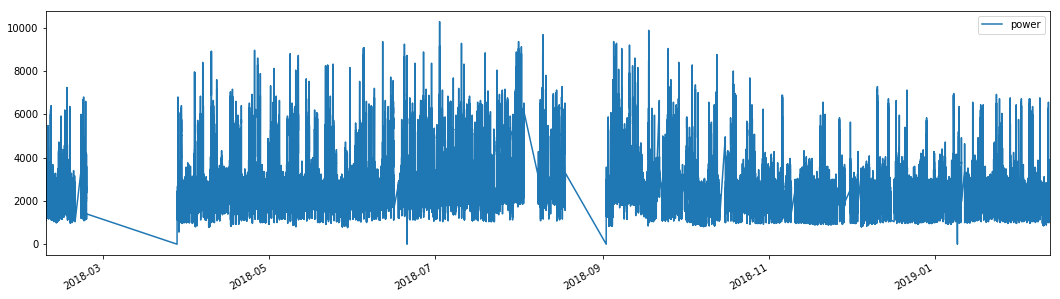

In [4]:
df_power.plot(figsize=(18,5))

### Check for missing data

In [5]:
df_power.isna().any()

power    False
dtype: bool

### Clean data

In [6]:
# Resample to 5min
df_processed = df_power.resample('5T').mean()

df_processed.head()

,power
2018-02-07 22:05:00+00:00,2193.846154
2018-02-07 22:10:00+00:00,2185.263158
2018-02-07 22:15:00+00:00,2861.052632
2018-02-07 22:20:00+00:00,2153.513514
2018-02-07 22:25:00+00:00,3000.000000


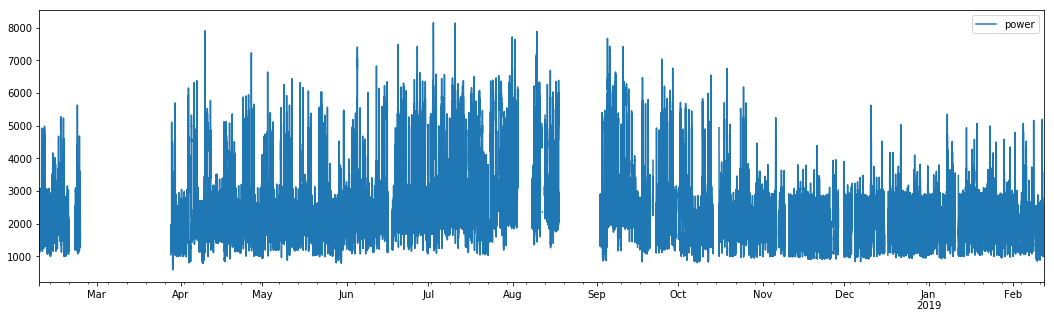

In [7]:
df_processed.plot(figsize=(18,5))

### Check for missing data

In [8]:
print(df_processed.isna().any())
print('\n')
missing = df_processed['power'].isnull().sum()
total = df_processed['power'].shape[0]
print('% Missing data for power: ', (missing/total)*100, '%')

power    True
dtype: bool


% Missing data for power:  21.789799159798125 %


### Depending on the percent missing data, either drop it or forward fill the NaN's

In [9]:
# Option 1: Drop NaN's
df_processed.dropna(inplace=True)

# # Option 2: ffill NaN's
# df_processed = df_processed.fillna(method='ffill')

### Normalize data

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
df_normalized = pd.DataFrame(scaler.fit_transform(df_processed), 
                             columns=df_processed.columns, index=df_processed.index)
df_normalized.head()

,power
2018-02-07 22:05:00+00:00,0.212181
2018-02-07 22:10:00+00:00,0.211045
2018-02-07 22:15:00+00:00,0.300492
2018-02-07 22:20:00+00:00,0.206843
2018-02-07 22:25:00+00:00,0.318882


### Check for missing data

In [11]:
df_normalized.isna().any()

power    False
dtype: bool

## Check for stationarity

In [12]:
result = adfuller(df_normalized['power'], autolag='AIC')
output = pd.Series(result[0:4], index=['Test Statistic', 'p-value', '#Lags Used',
                                      '#Observations Used'])
for key, value in result[4].items():
    output['Critical Value (%s)' % key] = value
    
output

Test Statistic            -23.974046
p-value                     0.000000
#Lags Used                 35.000000
#Observations Used      83182.000000
Critical Value (1%)        -3.430429
Critical Value (5%)        -2.861575
Critical Value (10%)       -2.566788
dtype: float64

## HVAC States data

In [13]:
df_hvac_states = pd.read_csv(hvac_states_data_folder + '/hvac_states_' + site + '.csv', 
                                 index_col=[0], parse_dates=True)
df_hvac_states.columns = ['zone' + str(i) for i in range(len(df_hvac_states.columns))]
df_hvac_states.head()

,zone0
2018-01-01 00:00:00+00:00,0.0
2018-01-01 00:05:00+00:00,0.0
2018-01-01 00:10:00+00:00,0.0
2018-01-01 00:15:00+00:00,0.0
2018-01-01 00:20:00+00:00,0.0


### Check for missing data

In [14]:
df_hvac_states.isna().any()

zone0    True
dtype: bool

### Convert categorical (HVAC states) into dummy variables

In [15]:
var_to_expand = df_hvac_states.columns

# One-hot encode the HVAC states
for var in var_to_expand:

    add_var = pd.get_dummies(df_hvac_states[var], prefix=var, drop_first=True)

    # Add all the columns to the model data
    df_hvac_states = df_hvac_states.join(add_var)

    # Drop the original column that was expanded
    df_hvac_states.drop(columns=[var], inplace=True)
    
df_hvac_states.head()

,zone0_1.0,zone0_2.0,zone0_5.0
2018-01-01 00:00:00+00:00,0,0,0
2018-01-01 00:05:00+00:00,0,0,0
2018-01-01 00:10:00+00:00,0,0,0
2018-01-01 00:15:00+00:00,0,0,0
2018-01-01 00:20:00+00:00,0,0,0


In [16]:
# def func(row):
#     """ Possible situations: (0,0,0), (1,0,1), (0,1,2) --> 0, 1, 2
    
#     If all are same --> first element
#     If there is a majority among the 3 --> majority
#     If all are unique --> last element
    
#     """

#     count = len(set(list(row.values)))
#     if count == 1:
#         return row.values[0]
#     elif count == 2:
#         max(set(list(row.values)), key=list(row.values).count)
#     else:
#         return row.values[-1]
    
# resample_df_hvac = df_raw_hvac_states.resample('15T').apply(func)

# resample_df_hvac = resample_df_hvac.fillna(method='ffill')
# resample_df_hvac.isna().any()

# Join power and hvac_states data

In [17]:
# CHECK: pd.concat gives a lot of duplicate indices. 
# Try below code to see duplicates,
# start = pd.Timestamp('2018-02-10 06:00:00+00:00')
# df.loc[start]

df = pd.concat([df_normalized, df_hvac_states], axis=1)
df.head()

,power,zone0_1.0,zone0_2.0,zone0_5.0
2018-01-01 00:00:00+00:00,NaN,0,0,0
2018-01-01 00:05:00+00:00,NaN,0,0,0
2018-01-01 00:10:00+00:00,NaN,0,0,0
2018-01-01 00:15:00+00:00,NaN,0,0,0
2018-01-01 00:20:00+00:00,NaN,0,0,0


In [18]:
df = df.drop_duplicates()

In [19]:
missing = df.isnull().sum()
total = df.shape[0]
print('missing data for power: ', (missing/total)*100, '%')

missing data for power:  power        0.01381
zone0_1.0    0.00000
zone0_2.0    0.00000
zone0_5.0    0.00000
dtype: float64 %


### Depending on the percent missing data, either drop it or forward fill the NaN's

In [20]:
# Option 1: Drop NaN's
df.dropna(inplace=True)

# # Option 2: ffill NaN's
# df = df.fillna(method='ffill')

# Visualizations

## Box plot

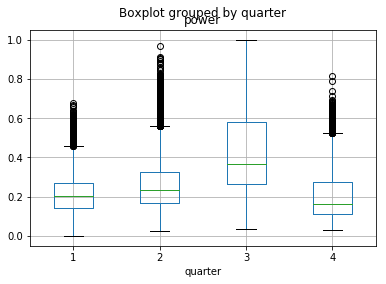

In [21]:
df_box_plot = pd.DataFrame(df['power'])
df_box_plot['quarter'] = df_box_plot.index.quarter
df_box_plot.boxplot(column='power', by='quarter')

## Histogram

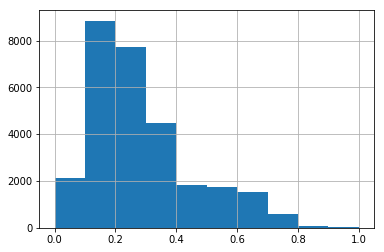

In [22]:
df['power'].hist()

## ACF and PACF

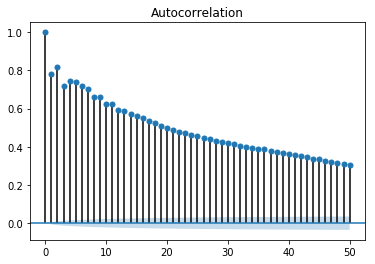

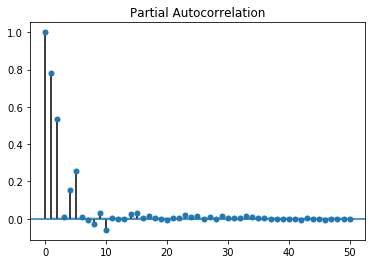

In [23]:
fig1 = plot_acf(df_processed['power'], lags=50)
fig2 = plot_pacf(df_processed['power'], lags=50)

# Prepare data

## Split into training & testing data

In [24]:
X_train = df[(df.index < '2019-01-01')]
y_train = df.loc[(df.index < '2019-01-01'), 'power']

X_test = df[(df.index >= '2019-01-01')]
y_test = df.loc[(df.index >= '2019-01-01'), 'power']

## Prepare data for LSTM

Note: NUM_TIMESTEPS is a hyper-parameter too!

In [38]:
# Number of columns in X_train
NUM_FEATURES    = len(X_train.columns)

# A sequence contains NUM_TIMESTEPS number of elements and predicts NUM_PREDICTIONS number of predictions
NUM_TIMESTEPS   = 288

# 4 hour predictions = Fourty eight 5min predictions 
NUM_PREDICTIONS = 48

In [39]:
train_x, train_y = [], []
for i in range(NUM_TIMESTEPS, len(X_train)-NUM_PREDICTIONS):
    train_x.append(X_train.values[i-NUM_TIMESTEPS:i])
    train_y.append(y_train.values[i:i+NUM_PREDICTIONS]) 
train_x, train_y = np.array(train_x), np.array(train_y)
print(train_x.shape)
print(train_y.shape)

test_x, test_y = [], []
for i in range(NUM_TIMESTEPS, len(X_test)-NUM_PREDICTIONS):
    test_x.append(X_test.values[i-NUM_TIMESTEPS:i])
    test_y.append(y_test.values[i:i+NUM_PREDICTIONS])   
test_x, test_y = np.array(test_x), np.array(test_y)
print(test_x.shape)
print(test_y.shape)

(27038, 288, 4)
(27038, 48)
(1251, 288, 4)
(1251, 48)


# LSTM

In [50]:
model = Sequential([
    
    LSTM(units=64, activation='relu', input_shape=(NUM_TIMESTEPS, NUM_FEATURES), return_sequences=True),
    Dropout(0.2),
    
    LSTM(units=128, activation='relu', return_sequences=True),
    Dropout(0.2),
    
    LSTM(units=128, activation='softmax', return_sequences=False),
    Dropout(0.2),
    
    Dense(64),
    Dense(NUM_PREDICTIONS)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 288, 64)           17664     
_________________________________________________________________
dropout_7 (Dropout)          (None, 288, 64)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 288, 128)          98816     
_________________________________________________________________
dropout_8 (Dropout)          (None, 288, 128)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
__________

In [51]:
# Stop training if validation loss fails to decrease
callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1)]

history = model.fit(train_x, train_y, 
                    epochs=100, batch_size=128, shuffle=False, 
                    validation_data=(test_x, test_y), callbacks=callbacks)

Train on 27038 samples, validate on 1251 samples
Epoch 1/100
14336/27038 [==============>...............] - ETA: 2:20 - loss: 0.0250 - acc: 0.0176

KeyboardInterrupt: 

# Results

## Loss

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = [x for x in range(len(train_loss))]

df_train_loss = pd.DataFrame(train_loss, columns=['train_loss'], index=epochs)
df_val_loss   = pd.DataFrame(val_loss, columns=['val_loss'], index=epochs)

df_loss = pd.concat([df_train_loss, df_val_loss], axis=1)

In [ ]:
df_loss.plot(figsize=(18,5))

## Accuracy

In [ ]:
train_acc = history.history['acc']
val_acc   = history.history['val_acc']
epochs    = [x for x in range(len(train_acc))]

df_train_acc = pd.DataFrame(train_acc, columns=['train_acc'], index=epochs)
df_val_acc   = pd.DataFrame(val_acc, columns=['val_acc'], index=epochs)

df_acc = pd.concat([df_train_acc, df_val_acc], axis=1)

In [ ]:
df_acc.plot(figsize=(18,5))

# Predictions

## Make predictions through trained model

In [ ]:
pred_y = model.predict(test_x)

## Convert predicted and actual values to dataframes (for plotting)

In [ ]:
df_y_pred = pd.DataFrame(scaler.inverse_transform(pred_y),
                         index=y_test[NUM_TIMESTEPS:-NUM_PREDICTIONS].index)

df_y_true = pd.DataFrame(scaler.inverse_transform(test_y),
                         index=y_test[NUM_TIMESTEPS:-NUM_PREDICTIONS].index)

In [ ]:
df_y_pred.head()

## Plot a particular timestamp

In [ ]:
# If this gives error, the timestamp probably doesn't exist in df_y_pred & df_y_true.
# Try different timestamp.
timestamp = pd.Timestamp('2019-01-01 23:45:00+00:00')

predictions  = df_y_pred.loc[timestamp, :]
ground_truth = df_y_true.loc[timestamp, :]

df_plot = pd.concat([predictions, ground_truth], axis=1)
df_plot.columns = ['pred', 'true']

In [ ]:
df_plot.plot(figsize=(18,5))